In [ ]:
%tensorflow_version 2.x

!pip install tensorboardX
# !pip install tensorflow-gpu 

# !pip install tf_slim


     |████████████████████████████████| 124 kB 7.4 MB/s 


In [ ]:
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !pip install -U colabgymrender

# from colabgymrender.recorder import Recorder

In [ ]:

# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import tensorflow as tf
import collections
import datetime
# import tf_slim as slim
from tensorboardX import SummaryWriter
import random
import time
from gym.wrappers import Monitor
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline               

In [ ]:

# import glob
# import io
# import base64
# from IPython.display import HTML
# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay
# display = Display(visible=0, size=(1400, 900))
# display.start()

# def show_video():
#   mp4list = glob.glob('video/*.mp4')
#   if len(mp4list) > 0:
#     mp4 = mp4list[0]
#     video = io.open(mp4, 'r+b').read()
#     encoded = base64.b64encode(video)
#     ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#                 loop controls style="height: 400px;">
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii'))))
#   else: 
#     print("Could not find video")
    

# def wrap_env(env):
#   env = Monitor(env, './video', force=True)
#   return env

#Section 1

##Models

In [ ]:
from datetime import datetime
import time
from matplotlib import pyplot as plt
import gym
import os
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation, concatenate   # , Reshape
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import GradientTape, math, one_hot, square, summary, config
import keras.backend as K
from tensorflow.keras.utils import plot_model



### Neural Network

In [ ]:
# class LearningRateLoggingCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch):
#         lr = self.model.optimizer.lr
#         tf.summary.scalar('learning rate', data=lr, step=epoch)


class NeuralNetwork(object):
    """
    Neural network class
    """

    def __init__(self, input_size, output_size, hidden_layers, init_learning_rate,
                 decay_steps, decay_rate, loss="mse",weights=None):
        """
        Initialize the Feed Forward Neural Network and the optimizer

        :param input_size: the length of the input
        :param output_size: the length of the output
        :param hidden_layers: list of the size of the hidden layers
        :param init_learning_rate: the initial learning rate
        :param decay_steps: Decay steps of the learning rate
        :param decay_rate: Decay rate of the learning rate
        :param weights: if given, weights of the model
        :param loss: either "mse" or "categorical_crossentropy". detrmines the loss function and the output's layer activation (linear or softmax)
        """
        self.state_size = input_size
        self.input_size = input_size
        self.action_size = output_size
        self.output_size = output_size
        self.learning_rate = init_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.hidden_layers_sizes = hidden_layers
        self.loss = loss
        self.step = 0
        # self.layers = []

        # lr_schedule = ExponentialDecay(
        #     initial_learning_rate=init_learning_rate,
        #     decay_steps=decay_steps,
        #     decay_rate=decay_rate,
        #     staircase=True)
        self.learning_rate_dynamic = self.learning_rate * self.decay_rate ** (self.step / self.decay_steps)

        self.optimizer = Adam(learning_rate=self.get_lr)
        lr_metric = self.get_lr_metric(self.optimizer)
        self.model = self.create_model(input_size, output_size, layers=list(hidden_layers), lr_metric=lr_metric, loss=loss)
        if weights is not None:
            self.copy_weights(weights)

    # source: https://stackoverflow.com/questions/47490834/how-can-i-print-the-learning-rate-at-each-epoch-with-adam-optimizer-in-keras
    def get_lr_metric(self, optimizer):
        def lr(y_true, y_pred):
            return optimizer._decayed_lr("float32")

        return lr

    def create_model(self, input_size, output_size, lr_metric, loss, layers=[]):
        """
        Creates and returns Dense NN based on the given params

        :param input_size: the length of the input
        :param output_size: the length of the output
        :param layers: list of the size of the hidden layers
        :param lr_metric: Learning rate metric of the optimizer
        :param loss: either "mse" or "categorical_crossentropy". detrmines the loss function and the output's layer activation (linear or softmax)
        :return: dense NN
        """
        state_input = Input(shape=(input_size,), dtype='float64', name="states input")

        x = Dense(input_size, activation='relu')(state_input)  # , kernel_initializer='RandomNormal'
        for i in range(0, len(layers)):
            x = Dense(layers[i], activation='relu')(x)
            # x = BatchNormalization()(x)
            # x = Dropout(0.2)(x)

        
        if loss == "mse":
          x = Dense(output_size, activation='linear')(x)
        elif loss == "categorical_crossentropy":
          x = Dense(output_size, activation='softmax')(x)

        model = Model(state_input, x)

        model.compile(loss=loss, optimizer=self.optimizer, metrics=['acc', lr_metric])

        model.summary()
        return model

    def predict(self, x, np_array=False):
        """
         use self.model to predict on the given x

        :param x: input for the model
        :return: prediction of the model on x
        """
        if np_array:
          return self.model(np.atleast_2d(x.astype('float64')))
        else:
          return self.model(x)
    
    def convert_to_progressive(self, sources_models):
      input = Input(shape=(self.input_size,), dtype='float64', name="input")

      frozen_intermediate_layers_models = []
      sources_models_layers_otputs = []
      for source_model in sources_models:

        # #remove last layer
        # layer_input = source_model.input
        # layer_output = source_model.layers[-1].output
        # sliced_source_model = Model(inputs=layer_input, outputs=layer_output)
        # sliced_source_model.summary()
        current_frozen_intermediate_layers_models = {}
        current_sources_models_layers_otputs = {}
        #replacing the input layer to be the joint input
        for layer_index, layer in enumerate(source_model.layers[1:]):
          layer_output = layer.output
          intermediate_layer_model = Model(inputs=source_model.input, outputs=layer_output)
          print("\n\nintermediate_layer_model.summary()")
          intermediate_layer_model.summary()
          intermediate_layer_model.layers.pop(0)
          # output of layer = intermediate_layer_model(input, training=False)
          new_output = intermediate_layer_model(input, training=False)
          frozen_intermediate_layer_model = Model(inputs=input, outputs=new_output)
          for layer in frozen_intermediate_layer_model.layers:
            layer.trainable = False
          current_frozen_intermediate_layers_models[layer_index] = frozen_intermediate_layer_model
          current_sources_models_layers_otputs[layer_index] = new_output
        frozen_intermediate_layers_models.append(current_frozen_intermediate_layers_models)
        sources_models_layers_otputs.append(current_sources_models_layers_otputs)

      #constructing the progressive network 
      x = Dense(self.input_size, activation='relu')(input) 

      # [print(frozen_source_model.layers) for frozen_source_model in frozen_source_models]
      
      for layer_index, layer_size in enumerate(self.hidden_layers_sizes):
        level_layers=[x]
        for source_model_layers_otputs in sources_models_layers_otputs:
          level_layers.append(source_model_layers_otputs[layer_index])
        print("level_layers", level_layers)
        x = Dense(layer_size, activation='relu')(concatenate(level_layers))

      last_level_layers=[x]
      for source_model_layers_otputs in sources_models_layers_otputs:
        print("source_model_layers_otputs", source_model_layers_otputs)
        print("len(source_model_layers_otputs)", len(source_model_layers_otputs))
        last_level_layers.append(source_model_layers_otputs[len(source_model_layers_otputs)-2])
      if self.loss == "mse":
        x = Dense(self.output_size, activation='linear')(concatenate(last_level_layers))
      elif self.loss == "categorical_crossentropy":
        x = Dense(self.output_size, activation='softmax')(concatenate(last_level_layers))

      model = Model(input, x)
      self.learning_rate_dynamic = self.learning_rate * self.decay_rate ** (self.step / self.decay_steps)
      self.model.optimizer = Adam(learning_rate=self.get_lr)
      lr_metric = self.get_lr_metric(self.optimizer)
      model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['acc', lr_metric])
      model.summary()
      self.model=model
    # def convert_to_progressive(self, sources_models):
    #   #model3 = Model(input=model2.input, output=[o])

    #   input = Input(shape=(self.input_size,), dtype='float64', name="input")

    #   frozen_source_models = []
    #   for source_model in sources_models:
    #     # #remove last layer
    #     # layer_input = source_model.input
    #     # layer_output = source_model.layers[-1].output
    #     # sliced_source_model = Model(inputs=layer_input, outputs=layer_output)
    #     # sliced_source_model.summary()
    #     #replacing the input layer to be the joint input
    #     source_model.layers.pop(0)
    #     new_output = source_model(input, training=False)
    #     frozen_source_model = Model(inputs=input, outputs=new_output)
    #     frozen_source_model.summary()
    #     for layer in frozen_source_model.layers:
    #       layer.trainable = False
    #     frozen_source_models.append(frozen_source_model)

    #   x = Dense(self.input_size, activation='relu')(input)  # , kernel_initializer='RandomNormal'

    #   [print(frozen_source_model.layers) for frozen_source_model in frozen_source_models]
      
    #   for layer_index, layer_size in enumerate(self.hidden_layers_sizes):
    #     level_layers=[x]
    #     for source_model in frozen_source_models:
    #       level_layers.append(source_model.layers[layer_index])
    #     print("level_layers", level_layers)
    #     x = Dense(layer_size, activation='relu')(concatenate(level_layers))

    #   last_level_layers=[x]
    #   for source_model in frozen_source_models:
    #     last_level_layers.append(source_model.layers[-1])
    #   if self.loss == "mse":
    #     x = Dense(self.output_size, activation='linear')(concatenate(last_level_layers))
    #   elif self.loss == "categorical_crossentropy":
    #     x = Dense(self.output_size, activation='softmax')(concatenate(last_level_layers))

    #   model = Model(input, x)
    #   self.learning_rate_dynamic = self.learning_rate * self.decay_rate ** (self.step / self.decay_steps)
    #   self.model.optimizer = Adam(learning_rate=self.get_lr)
    #   lr_metric = self.get_lr_metric(self.optimizer)
    #   model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['acc', lr_metric])
    #   model.summary()
    #   self.model=model

    def convert_to_transfer_model(self):
      #trasfer weights
      layer_input = self.model.input
      layer_output = self.model.layers[-2].output
      intermediate_layer_model = Model(inputs=layer_input, outputs=layer_output)

      input = Input(shape=(self.input_size,), dtype='float64', name="states input")
      x = intermediate_layer_model(input, training=False)
      
      #add a new output layer
      if self.loss == "mse":
          x = Dense(self.output_size, activation='linear')(x)
      elif self.loss == "categorical_crossentropy":
          x = Dense(self.output_size, activation='softmax')(x)
      
      # lr_schedule = ExponentialDecay(
      #       initial_learning_rate=self.learning_rate,
      #       decay_steps=self.decay_steps,
      #       decay_rate=self.decay_rate,
      #       staircase=True)
      self.learning_rate_dynamic = self.learning_rate * self.decay_rate ** (self.step / self.decay_steps)


      self.model.optimizer = Adam(learning_rate=self.get_lr)
      lr_metric = self.get_lr_metric(self.optimizer)

      self.transfer_model = Model(input, x)
      self.transfer_model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['acc', lr_metric])
      for layer in self.transfer_model.layers[:-1]:
        layer.trainable = False
      self.transfer_model.summary()
      self.model = self.transfer_model
    
    def get_lr(self):
      return self.learning_rate_dynamic

    def update_lr(self):
      self.step = self.step + 1
      self.learning_rate_dynamic = self.learning_rate * self.decay_rate ** (self.step / self.decay_steps)
      


    def predict_logits(self, x, np_array=False):
      layer_input = self.model.input
      layer_output = self.model.layers[-2].output
      intermediate_layer_model = Model(inputs=layer_input, outputs=layer_output)
      if np_array:
        return intermediate_layer_model(np.atleast_2d(x.astype('float64')))
      else:
        return intermediate_layer_model(x)

    def copy_weights(self, other_weights):
        """
        copies the given weights to self.model

        :param other_weights: weights of a different model with the same structure
        """
        # owm_weights = self.model.trainable_variables
        # for v1, v2 in zip(owm_weights, other_weights):
        #     v1.assign(v2.numpy())
        self.model.set_weights(other_weights)

    def save(self, time_stamp, env_name, prefix="policy"):
        base_path =f"./trained_internal_models/{env_name}"
        if not os.path.isdir(base_path):
            os.makedirs(base_path)

        # serialize model to JSON
        model_json = self.model.to_json()
        with open(base_path + f"/{prefix}_{time_stamp}.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights(base_path + f"/{prefix}_{time_stamp}_weights.h5")
        print(f"Saved model to disk num: {prefix} {time_stamp}")
    
    def load(self, time_stamp, env_name, prefix="policy"):
        base_path =f"./trained_internal_models/{env_name}"
        if not os.path.isdir(base_path):
            print("no model was saved yet")
        else:
            # load json and create model
            json_file = open(base_path + f"/{prefix}_{time_stamp}.json", 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            self.model = model_from_json(loaded_model_json)
            # load weights into new model
            self.model.load_weights(base_path + f"/{prefix}_{time_stamp}_weights.h5")
            
            self.learning_rate_dynamic = self.learning_rate * self.decay_rate ** (self.step / self.decay_steps)
            self.model.optimizer = Adam(learning_rate=self.get_lr)
            lr_metric = self.get_lr_metric(self.optimizer)

            self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['acc', lr_metric])
            print("Loaded model from disk")
    

### Actor-Critic Agent

In [ ]:
class ActorCriticAgent(object):
  def __init__(self, state_size, action_size, policy_learning_rate, value_learning_rate, 
               policy_hidden_layers, value_hidden_layers, policy_decay_rate, value_decay_rate,
               policy_decay_steps, value_decay_steps):
    self.state_size = state_size
    self.action_size = action_size
    np.random.seed(2)
    # tf.reset_default_graph()
    # Initialize the policy network
    self.policy = NeuralNetwork(input_size=state_size, output_size=action_size,
                                hidden_layers=policy_hidden_layers, init_learning_rate=policy_learning_rate,
                                decay_steps=policy_decay_steps, decay_rate=policy_decay_rate,
                                loss="categorical_crossentropy",weights=None)
    # Initialize the value network
    self.value = NeuralNetwork(input_size=state_size, output_size=1,
                                hidden_layers=list(value_hidden_layers), init_learning_rate=value_learning_rate,
                                decay_steps=value_decay_steps, decay_rate=value_decay_rate,
                                loss="mse",weights=None)

  def save_models(self, env_name):
    time_stamp = datetime.now()
    self.policy.save(time_stamp, env_name, prefix="policy")
    self.value.save(time_stamp, env_name, prefix="value")


  def train(self, env, env_actions_count, convergence_criterion, max_episodes, max_steps, discount_factor, scaler, scale=False, discretize=[], render=False, plot=True, init_noise=1,noise_decay=0.9999):
    np.random.seed(1)
    writer = SummaryWriter()
    
    # Start training the agent with REINFORCE algorithm
    start_time = time.time()

    # with tf.Session() as sess:
    #   sess.run(tf.global_variables_initializer())
    solved = False
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    episode_rewards = np.zeros(max_episodes)
    average_rewards = 0.0
    for episode in range(max_episodes):
        state = env.reset()
        state = np.pad(state, (0,self.state_size-len(state)))
        state = state.reshape([1, self.state_size]) #NOTE
        if scale:
          state = scaler.state_scale(state)

        I = 1
        episode_transitions = []
        episode_val_losses = []
        episode_policy_losses = []

        for step in range(max_steps):
            self.policy.update_lr()
            self.value.update_lr()

            actions_distribution = self.policy.predict(state)

            if len(discretize) > 0: #Continues
                actions_distribution = actions_distribution[0][:env_actions_count].numpy()
                #add noise to action selection
                init_noise=init_noise*noise_decay
                noise = np.random.normal(0, 1, env_actions_count) * init_noise
                actions_distribution = actions_distribution + noise
                #select action 
                action = random.choices(np.arange(env_actions_count), weights=actions_distribution)[0]
                action_one_hot = one_hot(action, self.action_size)
                # # noisy action
                action = [discretize[action]]
            else:    
                action = random.choices(np.arange(env_actions_count), weights=actions_distribution[0][:env_actions_count])[0]
                action_one_hot = one_hot(action, self.action_size)
            next_state, reward, done, _ = env.step(action)

            next_state = np.pad(next_state, (0,self.state_size-len(next_state)))
            next_state = next_state.reshape([1, self.state_size]) #NOTE
            if scale:
              next_state = scaler.state_scale(next_state)
            # if render:
            #     env.render()
            
            episode_transitions.append(Transition(state=state, action=action_one_hot, reward=reward, next_state=next_state, done=done))
            
            episode_rewards[episode] += reward

            # Compute value estimations
            estimated_return_state = self.value.predict(state)
            if not done:
              estimated_return_next_state = self.value.predict(next_state)
              discounted_estimated_return_next_state = discount_factor * estimated_return_next_state
            else:
              discounted_estimated_return_next_state = 0
            # Compute TD-error 
            delta = (reward + discounted_estimated_return_next_state) - estimated_return_state
            delta_I = I * delta
            
            # Value function update
            with GradientTape() as tape:
              # val_loss = self.value.model.compiled_loss((reward + discounted_estimated_return_next_state), estimated_return_state)
              val_loss = math.reduce_mean(square((reward + discounted_estimated_return_next_state) - self.value.predict(state)))
            # print("val_loss", val_loss)
            # print("val_loss", val_loss.numpy())
            variables = self.value.model.trainable_weights
            gradients = tape.gradient(val_loss, variables)
            # print("gradients", gradients)
            self.value.optimizer.apply_gradients(zip(gradients, variables))

            # value_feed_dict= {self.value.state: state, self.value.R_t: reward + discounted_estimated_return_next_state} 
            # _, val_loss = sess.run([self.value.optimizer, self.value.loss], value_feed_dict)
            episode_val_losses.append(val_loss)

            # Policy function update
            with GradientTape() as tape:
              neg_log_prob = self.policy.model.compiled_loss(y_true=tf.expand_dims(action_one_hot, axis=0), y_pred=self.policy.predict(state))
              # loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
              # print("neg_log_prob", neg_log_prob)
              # neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, labels=action_one_hot)
              policy_loss = tf.reduce_mean(neg_log_prob * delta_I)
              # print("policy_loss", policy_loss)

            variables = self.policy.model.trainable_weights
            gradients = tape.gradient(policy_loss, variables)
            self.policy.optimizer.apply_gradients(zip(gradients, variables))

            episode_policy_losses.append(policy_loss)
            
            if step+1 == max_steps:
              done=True
            if done:
                if episode > 98:
                    # Check if solved
                    average_rewards = np.mean(episode_rewards[(episode - 99):episode+1])
                    # print("episode_rewards", episode_rewards[(episode - 99):episode+1])
                print("Episode {}".format(episode))
                print(f"Reward: {episode_rewards[episode]},Average 100 episodes: {round(average_rewards, 2)}, Mean Value Loss: {np.mean(episode_val_losses)}, Mean Policy Loss: {np.mean(episode_policy_losses)}")
                solved = convergence_criterion(average_rewards)
                print("value lr:", self.value.optimizer._decayed_lr(tf.float32).numpy(), "policy lr:", self.policy.optimizer._decayed_lr(tf.float32).numpy(), "noise:", init_noise)
                if solved:
                    print(' Solved at episode: ' + str(episode))
                break
            state = next_state
            I = discount_factor * I
        writer.add_scalar('Total Reward', episode_rewards[episode], episode)
        writer.add_scalar('Steps', step, episode)
        # if render:
        #   env.play()

        if solved:
            break

    writer.close()

    end_time = time.time()
    print(f"execution time (sec): {end_time - start_time}")
    if plot:
      plt.plot(range(episode),episode_rewards[:episode])
      plt.xlabel('Eposode')
      plt.ylabel('Rewards')
      plt.title('The total rewared')
      plt.show()
    
    return solved

### Actor-Critic Agent - Experience Replay

In [ ]:
def sample_batch(deque_to_sample_from, n):
  """
  Randomly (Uniformly) samples n instances from a given deque

  :param deque_to_sample_from: a deque to sample from
  :param n: the number of instances to sample
  :return: the sampled instances
  """
  m = min(n, len(deque_to_sample_from))
  batch = random.sample(list(deque_to_sample_from), m)
  return batch

class ActorCriticAgent_2(object):
  def __init__(self, state_size, action_size, policy_learning_rate, value_learning_rate, 
               policy_hidden_layers, value_hidden_layers, policy_decay_rate, value_decay_rate,
               policy_decay_steps, value_decay_steps):
    self.state_size = state_size
    self.action_size = action_size
    np.random.seed(1)
    # tf.reset_default_graph()
    # Initialize the policy network
    self.policy = NeuralNetwork(input_size=state_size, output_size=action_size,
                                hidden_layers=policy_hidden_layers, init_learning_rate=policy_learning_rate,
                                decay_steps=policy_decay_steps, decay_rate=policy_decay_rate,
                                loss="categorical_crossentropy",weights=None)
    # Initialize the value network
    self.value = NeuralNetwork(input_size=state_size, output_size=1,
                                hidden_layers=list(value_hidden_layers), init_learning_rate=value_learning_rate,
                                decay_steps=value_decay_steps, decay_rate=value_decay_rate,
                                loss="mse",weights=None)

  def save_models(self, env_name):
    time_stamp = datetime.now()
    self.policy.save(time_stamp, env_name, prefix="policy")
    self.value.save(time_stamp, env_name, prefix="value")
  
  def train(self, env, env_actions_count, convergence_criterion, max_episodes, max_steps, discount_factor, scaler, scale=False, discretize=[], render=False, plot=True, batch_size=16, experience_size=2000, init_noise=1,noise_decay=0.9999):
    np.random.seed(1)
    writer = SummaryWriter()
    # Start training the agent with REINFORCE algorithm
    start_time = time.time()

    # with tf.Session() as sess:
    #   sess.run(tf.global_variables_initializer())
    solved = False
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    episode_rewards = np.zeros(max_episodes)
    average_rewards = 0.0
    experience_replay = deque(maxlen=experience_size)

    for episode in range(max_episodes):
        state = env.reset()
        state = np.pad(state, (0,self.state_size-len(state)))
        state = state.reshape([1, self.state_size]) #NOTE
        if scale:
          state = scaler.state_scale(state)

        I = 1
        episode_val_losses = []
        episode_policy_losses = []

        for step in range(max_steps):
            self.policy.update_lr()
            self.value.update_lr()

            actions_distribution = self.policy.predict(state)
            if len(discretize) > 0: #Continues
                actions_distribution = actions_distribution[0][:env_actions_count].numpy()
                #add noise to action selection
                init_noise=init_noise*noise_decay
                noise = np.random.normal(0, 0.2, env_actions_count) * init_noise
                actions_distribution = actions_distribution + noise
                #select action 
                action = random.choices(np.arange(env_actions_count), weights=actions_distribution)[0]
                action_one_hot = one_hot(action, self.action_size)
                action = [discretize[action]]
            else:    
                action = random.choices(np.arange(env_actions_count), weights=actions_distribution[0][:env_actions_count])[0]
                action_one_hot = one_hot(action, self.action_size)
            next_state, reward, done, _ = env.step(action)

            next_state = np.pad(next_state, (0,self.state_size-len(next_state)))
            next_state = next_state.reshape([1, self.state_size]) #NOTE
            if scale:
              next_state = scaler.state_scale(next_state)
            # if render:
            #     env.render()
            
            experience_replay.append(Transition(state=state, action=action_one_hot, reward=reward, next_state=next_state, done=done))
            
            episode_rewards[episode] += reward
            
            # mini batch
            transitions_batch = sample_batch(experience_replay, batch_size)

            states_batch = []
            actions_one_hot_batch = []
            discounted_estimated_return_next_state_batch = []
            delta_I_batch = []
            for transition in transitions_batch:
              states_batch.append(transition.state[0])
              actions_one_hot_batch.append(transition.action)
              if not transition.done:
                estimated_return_next_state = self.value.predict(transition.next_state)
                discounted_estimated_return_next_state =  transition.reward + discount_factor * estimated_return_next_state
              else:
                discounted_estimated_return_next_state = transition.reward + 0
              discounted_estimated_return_next_state_batch.append(discounted_estimated_return_next_state)
              
              estimated_return_state = self.value.predict(transition.state)
              delta = discounted_estimated_return_next_state - estimated_return_state
              delta_I_batch.append(I * delta)
            
            states_batch = np.asarray(states_batch)
            actions_one_hot_batch = tf.convert_to_tensor(actions_one_hot_batch)
            discounted_estimated_return_next_state_batch = np.asarray(discounted_estimated_return_next_state_batch)
            delta_I_batch = np.asarray(delta_I_batch)
            # Value function update
            with GradientTape() as tape:
              # val_loss = self.value.model.compiled_loss((reward + discounted_estimated_return_next_state), estimated_return_state)
              val_loss = math.reduce_mean(square(discounted_estimated_return_next_state_batch - self.value.predict(states_batch)))
            # print("val_loss", val_loss)
            # print("val_loss", val_loss.numpy())
            variables = self.value.model.trainable_weights
            gradients = tape.gradient(val_loss, variables)
            # print("gradients", gradients)
            self.value.optimizer.apply_gradients(zip(gradients, variables))

            # value_feed_dict= {self.value.state: state, self.value.R_t: reward + discounted_estimated_return_next_state} 
            # _, val_loss = sess.run([self.value.optimizer, self.value.loss], value_feed_dict)
            episode_val_losses.append(val_loss)

            # Policy function update
            with GradientTape() as tape:
              neg_log_prob = self.policy.model.compiled_loss(y_true=actions_one_hot_batch, y_pred=self.policy.predict(states_batch))
              # loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
              # print("neg_log_prob", neg_log_prob)
              # neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, labels=action_one_hot)
              policy_loss = tf.reduce_mean(neg_log_prob * delta_I_batch)
              # print("policy_loss", policy_loss)

            variables = self.policy.model.trainable_weights
            gradients = tape.gradient(policy_loss, variables)
            self.policy.optimizer.apply_gradients(zip(gradients, variables))

            episode_policy_losses.append(policy_loss)
            
            if step+1 == max_steps:
              done=True
            if done:
                if episode > 98:
                    # Check if solved
                    average_rewards = np.mean(episode_rewards[(episode - 99):episode+1])
                    # print("episode_rewards", episode_rewards[(episode - 99):episode+1])
                print("Episode {}".format(episode))
                print(f"Reward: {episode_rewards[episode]},Average 100 episodes: {round(average_rewards, 2)}, Mean Value Loss: {np.mean(episode_val_losses)}, Mean Policy Loss: {np.mean(episode_policy_losses)}")
                solved = convergence_criterion(average_rewards)
                print("value lr:", self.value.optimizer._decayed_lr(tf.float32).numpy(), "policy lr:", self.policy.optimizer._decayed_lr(tf.float32).numpy())
                if solved:
                    print(' Solved at episode: ' + str(episode))
                break
            state = next_state
            I = discount_factor * I
        writer.add_scalar('Total Reward', episode_rewards[episode], episode)
        writer.add_scalar('Steps', step, episode)
        # if render:
        #   env.play()

        if solved:
            break

    writer.close()

    end_time = time.time()
    print(f"execution time (sec): {end_time - start_time}")
    if plot:
      plt.plot(range(episode),episode_rewards[:episode])
      plt.xlabel('Eposode')
      plt.ylabel('Rewards')
      plt.title('The total rewared')
      plt.show()
    
    return solved

In [ ]:
from sklearn.preprocessing import MinMaxScaler

class StateScaler:
    def __init__(self, env, padding):
        state_space_samples = np.array(
            [np.pad(env.observation_space.sample(), (0, padding), 'constant') for x in range(10000)])
        self.scaler = MinMaxScaler()
        self.scaler.fit(state_space_samples)
    def state_scale(self, state):
        return self.scaler.transform(state)
        

## Environments Setup

In [ ]:
envs_names = ['CartPole-v1',
              'Acrobot-v1',
              'MountainCarContinuous-v0'] 
mountain_car_discrit_actions = [-1, 1]

def get_env_actions_count(env):
  if len(env.action_space.shape) > 0:
    actions_count = env.action_space.shape[0]
  else:
    actions_count = env.action_space.n
  return actions_count

max_actions_count = len(mountain_car_discrit_actions)
max_states_count = 0
envs = {}
for env_name in envs_names:
  env = Monitor(gym.make(env_name), './video', force=True)

  actions_count = get_env_actions_count(env)

  states_count = env.observation_space.shape[0]
  
  envs[env_name] = {"env": gym.make(env_name), 
                    "actions_count": actions_count, 
                    "states_count": states_count}
  
  if actions_count > max_actions_count:
    max_actions_count = actions_count
  if states_count > max_states_count:
    max_states_count = states_count

In [ ]:
# Define hyperparameters
max_episodes = 500
max_steps = 1000
discount = 0.999

envs["CartPole-v1"].update({
    "layers_policy": [7, 6, 6], 
    "layers_value": [12], 
    "lr_policy": 0.003, 
    "lr_value":0.01, 
    "decay_steps_policy": 600, 
    "decay_steps_value": 850, 
    "decay_rate_policy": 0.88, 
    "decay_rate_value": 0.92,
    "discretize":[],
    "scale_states": False})

envs["Acrobot-v1"].update({
    "layers_policy": [7,7,6], 
    "layers_value": [12], 
    "lr_policy": 0.001, 
    "lr_value":0.01, 
    "decay_steps_policy": 1000, 
    "decay_steps_value": 1000, 
    "decay_rate_policy": 0.95, 
    "decay_rate_value": 0.98,
    "discretize":[],
    "scale_states": False})

envs['MountainCarContinuous-v0'].update({
    "layers_policy": [7,7,6], 
    "layers_value": [12], 
    "lr_policy": 0.001, 
    "lr_value":0.01, 
    "decay_steps_policy": 1000, 
    "decay_steps_value": 1000, 
    "decay_rate_policy": 0.95, 
    "decay_rate_value": 0.95,
    "discretize":[],
    "actions_count": len(mountain_car_discrit_actions), 
    "discretize": mountain_car_discrit_actions,
    "scale_states": True})

## Convergence Criterion

In [ ]:
def cart_pole_convergence_criterion(avg_rewards):
  if avg_rewards > 475:
    solved = True
  else:
    solved = False
  return solved

def acrobat_convergence_criterion(avg_rewards):
  if avg_rewards > -90 and avg_rewards !=0.0:
    solved = True
  else:
    solved = False
  return solved

def mountain_car_convergence_criterion(avg_rewards):
  if avg_rewards > 90:
    solved = True
  else:
    solved = False
  return solved

In [ ]:
envs['CartPole-v1']['convergence_criterion'] = cart_pole_convergence_criterion
envs['Acrobot-v1']['convergence_criterion'] = acrobat_convergence_criterion
envs['MountainCarContinuous-v0']['convergence_criterion'] = mountain_car_convergence_criterion

## Training Agents

{'env': <TimeLimit<CartPoleEnv<CartPole-v1>>>, 'actions_count': 2, 'states_count': 4, 'layers_policy': [7, 6, 6], 'layers_value': [12], 'lr_policy': 0.003, 'lr_value': 0.01, 'decay_steps_policy': 600, 'decay_steps_value': 850, 'decay_rate_policy': 0.88, 'decay_rate_value': 0.92, 'discretize': [], 'scale_states': False, 'convergence_criterion': <function cart_pole_convergence_criterion at 0x7f4808524710>, 'agent': <__main__.ActorCriticAgent object at 0x7f4808516090>}
{'env': <TimeLimit<AcrobotEnv<Acrobot-v1>>>, 'actions_count': 3, 'states_count': 6, 'layers_policy': [7, 7, 6], 'layers_value': [12], 'lr_policy': 0.001, 'lr_value': 0.01, 'decay_steps_policy': 1000, 'decay_steps_value': 1000, 'decay_rate_policy': 0.95, 'decay_rate_value': 0.98, 'discretize': [], 'scale_states': False, 'convergence_criterion': <function acrobat_convergence_criterion at 0x7f48085245f0>, 'agent': <__main__.ActorCriticAgent object at 0x7f4808e62c10>}
{'env': <TimeLimit<Continuous_MountainCarEnv<MountainCarCont

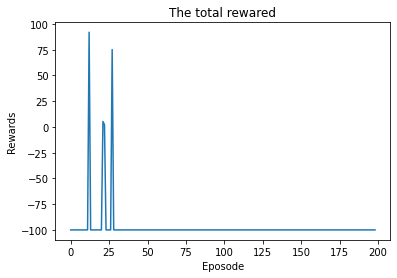

In [ ]:
for env_name, env_dict in envs.items():
  print(env_dict)
  # if env_name == 'MountainCarContinuous-v0':
  #   max_episodes = 200
  agent = ActorCriticAgent(state_size=max_states_count, action_size=max_actions_count, 
                           policy_learning_rate=env_dict["lr_policy"], value_learning_rate=env_dict["lr_value"],
                           policy_hidden_layers=env_dict["layers_policy"], value_hidden_layers=env_dict["layers_value"],
                           policy_decay_rate=env_dict["decay_rate_policy"], value_decay_rate=env_dict["decay_rate_value"],
                           policy_decay_steps=env_dict["decay_steps_policy"], value_decay_steps=env_dict["decay_steps_value"])
  padding = max_states_count - env_dict["actions_count"] 
  scaler = None
  if env_dict["scale_states"]:
    scaler = StateScaler(env, padding)
  solved = agent.train(env=env_dict["env"], env_actions_count=env_dict["actions_count"], convergence_criterion=env_dict["convergence_criterion"], max_episodes=max_episodes, max_steps=max_steps, discount_factor=discount, discretize=env_dict["discretize"], render=True, scaler=scaler, scale=env_dict["scale_states"])
  if solved:
    agent.save_models(env_name)
  env_dict["agent"] = agent

# Section 3

In [ ]:
def prepare_progressive(neural_model, source_models):
  print("original model - weights:", len(neural_model.model.weights))
  print("original model - trainable_weights:", len(neural_model.model.trainable_weights))
  print("original model - non_trainable_weights:", len(neural_model.model.non_trainable_weights))
  neural_model.convert_to_progressive(source_models)
  print("\ntransfer model - weights:", len(neural_model.model.weights))
  print("transfer model - trainable_weights:", len(neural_model.model.trainable_weights))
  print("transfer model - non_trainable_weights:", len(neural_model.model.non_trainable_weights))
  return neural_model


def get_source_networks(envs, source_tasks):
  source_policies = []
  source_values = []
  for source_task in source_tasks:
    source_task_dict = envs[source_task]
    source_task_agent = source_task_dict["agent"]
    source_policies.append(agent.policy.model)
    source_values.append(agent.value.model)

  return source_policies, source_values

##{Acrobot, mountainCar}->CartPole

In [ ]:
source_tasks = ["Acrobot-v1","MountainCarContinuous-v0"]
target_task = "CartPole-v1"

#target agent init
target_task_dict = envs[target_task]
target_agent = ActorCriticAgent(state_size=max_states_count, action_size=max_actions_count, 
                           policy_learning_rate=target_task_dict["lr_policy"], value_learning_rate=target_task_dict["lr_value"],
                           policy_hidden_layers=target_task_dict["layers_policy"], value_hidden_layers=target_task_dict["layers_value"],
                           policy_decay_rate=target_task_dict["decay_rate_policy"], value_decay_rate=target_task_dict["decay_rate_value"],
                           policy_decay_steps=target_task_dict["decay_steps_policy"], value_decay_steps=target_task_dict["decay_steps_value"])

#source agents
source_policies, source_values = get_source_networks(envs, source_tasks)

#converting the target networks to include the sources' networks 
target_agent.policy = prepare_progressive(target_agent.policy, source_policies)
target_agent.value = prepare_progressive(target_agent.value, source_values)


Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 states input (InputLayer)   [(None, 6)]               0         
                                                                 
 dense_80 (Dense)            (None, 6)                 42        
                                                                 
 dense_81 (Dense)            (None, 7)                 49        
                                                                 
 dense_82 (Dense)            (None, 6)                 48        
                                                                 
 dense_83 (Dense)            (None, 6)                 42        
                                                                 
 dense_84 (Dense)            (None, 3)                 21        
                                                                 
Total params: 202
Trainable params: 202
Non-trainable para

In [ ]:
target_agent.policy.model.summary()
target_agent.value.model.summary()

Model: "model_74"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 6)]          0           []                               
                                                                                                  
 dense_88 (Dense)               (None, 6)            42          ['input[0][0]']                  
                                                                                                  
 model_54 (Functional)          (None, 6)            42          ['input[0][0]']                  
                                                                                                  
 model_64 (Functional)          (None, 6)            42          ['input[0][0]']                  
                                                                                           

In [ ]:
# re-train 
target_agent.train(env=target_task_dict["env"], env_actions_count=target_task_dict["actions_count"], convergence_criterion=target_task_dict["convergence_criterion"], max_episodes=max_episodes, max_steps=max_steps, discount_factor=discount, discretize=target_task_dict["discretize"], render=True, scaler=None, scale=False)

##{CartPole, Acrobat}->mountainCar

In [ ]:
source_tasks = ["CartPole-v1", "Acrobot-v1"]
target_task = "MountainCarContinuous-v0"

#target agent init
target_task_dict = envs[target_task]
target_agent = ActorCriticAgent(state_size=max_states_count, action_size=max_actions_count, 
                           policy_learning_rate=target_task_dict["lr_policy"], value_learning_rate=target_task_dict["lr_value"],
                           policy_hidden_layers=target_task_dict["layers_policy"], value_hidden_layers=target_task_dict["layers_value"],
                           policy_decay_rate=target_task_dict["decay_rate_policy"], value_decay_rate=target_task_dict["decay_rate_value"],
                           policy_decay_steps=target_task_dict["decay_steps_policy"], value_decay_steps=target_task_dict["decay_steps_value"])

#source agents
source_policies, source_values = get_source_networks(envs, source_tasks)

#converting the target networks to include the sources' networks 
target_agent.policy = prepare_progressive(target_agent.policy, source_policies)
target_agent.value = prepare_progressive(target_agent.value, source_values)


In [ ]:
target_agent.policy.model.summary()
target_agent.value.model.summary()

In [ ]:
# re-train 
target_agent.train(env=target_task_dict["env"], env_actions_count=target_task_dict["actions_count"], convergence_criterion=target_task_dict["convergence_criterion"], max_episodes=max_episodes, max_steps=max_steps, discount_factor=discount, discretize=target_task_dict["discretize"], render=True, scaler=None, scale=False)

In [ ]:
%reload_ext tensorboard 
%tensorboard --logdir ".logs/"


In [ ]:

%reload_ext tensorboard
%tensorboard --logdir runs